### Authors:

Kasper Rønberg, s214786

Mads-Emil Leth Honoré, s214808

Lasse Bisp, s214807

Holger Lyng, s214776

# Traditional VAE
This notebook implements a traditional VAE. It is trained and evaluated on the LGG Segmentation dataset from kaggle. 

This notebook includes the following:

- Firstly packeges and helper functions are imported.

- Dataloaders are defined using a helper loading functions from the scripts/data.py.

- The model is defined using pytorch and pyro to efficiently define model structure.

- A custom elbo is defined to help with KL annealing.

- The model is trained and evaluated using helper functions from scripts/funcs.py.

- Lastly, images, ground truths, and sample predictions is visualized.

In [ ]:
# --- Import Libraries ---
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive
from pyro import poutine
from torch import nn
import sys
import os

sys.path.append(os.path.join(os.getcwd(), ".."))

# --- Import Custom Modules ---
from scripts.data import get_loaders
from scripts.funcs import run_model, print_losses

# Define device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


# --- Set Plot Style ---
sns.set_style("dark")
plt.style.use("dark_background")


# --- Define Parameters ---
BATCH_SIZE = 64
IMG_SIZE = 64
NUM_WORKERS = 0

/opt/homebrew/Caskroom/miniconda/base/envs/MBML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniconda/base/envs/MBML/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.7 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Define Dataloaders

In [2]:
train_loader, test_loader = get_loaders("../data/", batch_size=BATCH_SIZE, img_size=IMG_SIZE, num_workers=NUM_WORKERS)

Train set size: 3536
Test set size: 393


### Define Model

In [ ]:
# Define convolutional block
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

# Define Encoder
class Encoder(nn.Module):                       
    def __init__(self, z_dim=64):
        super().__init__()
        self.enc1 = double_conv(3,   16)
        self.enc2 = double_conv(16,  32)
        self.enc3 = double_conv(32,  64)
        self.enc4 = double_conv(64, 128)
        self.to_stats = nn.Sequential(           
            nn.Conv2d(128, 2*z_dim, 1),
            nn.AdaptiveAvgPool2d(1))
         
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        x5 = self.to_stats(x4).flatten(1)
        mu, log_sig = x5.chunk(2, dim=-1)

        return mu, torch.exp(0.5 * log_sig)

# Define Decoder
class Decoder(nn.Module):
    def __init__(self, z_dim=64, start_ch=128, img_size=32):
        super().__init__()
        self.img_size = img_size
        fsz = img_size // 16                             
        self.fc = nn.Linear(z_dim, start_ch * fsz * fsz)

        self.up1 = double_conv(start_ch, 128)
        self.up2 = double_conv(128,  64)
        self.up3 = double_conv(64,   32)
        self.up4 = double_conv(32,   16)

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear",
                                    align_corners=False)
        
        self.out_conv = nn.Conv2d(16, 1, 1)      

    def forward(self, z):
        B = z.size(0)
        fsz = self.img_size // 16
        x = self.fc(z).view(B, 128, fsz, fsz)

        x = self.up1(x)
        x = self.upsample(x)   
        x = self.up2(x) 
        x = self.upsample(x)   
        x = self.up3(x) 
        x = self.upsample(x)   
        x = self.up4(x) 
        x = self.upsample(x)  
        return torch.sigmoid(self.out_conv(x))          

                        

### Define VAE

In [4]:
# --- Define VAE ---
class VAE(nn.Module):
    def __init__(self, z_dim=6, input_dim=IMG_SIZE*IMG_SIZE*3):
        self.input_dim = input_dim
        self.output_dim = IMG_SIZE
        super().__init__()

        # Define the encoder and decoder networks
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim, img_size=self.output_dim)
        self.z_dim = z_dim

    # Define the model p(y|z)p(z)
    def model(self, x, y=None):
        pyro.module("decoder", self.decoder)
        batch_size = x.size(0)
        with pyro.plate("data", batch_size):

            # setup hyperparameters for prior p(z)
            z_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=device)
            z_scale = torch.ones(x.shape[0], self.z_dim, dtype=x.dtype, device=device)

            # sample from prior
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode the latent code z
            yhat = self.decoder.forward(z)

            if y is not None:
                pyro.sample("obs", 
                        dist.Bernoulli(yhat, validate_args=False).to_event(3), 
                        obs=y,)
            else:
                pyro.deterministic('obs', yhat.detach())

            return yhat

    # Define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x, y=None):
        # use the encoder to get the parameters used to define q(z|x)
        pyro.module("encoder", self.encoder)
        batch_size = x.size(0)
        with pyro.plate("data", batch_size):

            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)

            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

### Test forward paas

In [5]:
vae = VAE().to(device)
output = vae.model(torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device))
print(output.shape)

torch.Size([1, 1, 64, 64])


### Define the ELBO loss with KL annealing

In [ ]:
# --- Define KL Annealing Loss ---
def elbo_kl_annealing(model, guide, x, y=None, latents_to_anneal=["latent"], beta=1.0):
    # get the annealing factor and latents to anneal
    annealing_factor = beta
    latents_to_anneal = latents_to_anneal
    # run the guide and replay the model against the guide
    guide_trace = poutine.trace(
        guide).get_trace(x, y)
    
    model_trace = poutine.trace(
        poutine.replay(model, trace=guide_trace)).get_trace(x, y)

    elbo = 0.0
    # loop through all the sample sites in the model and guide trace and
    # construct the loss; note that we scale all the log probabilities of
    # samples sites in `latents_to_anneal` by the factor `annealing_factor`
    for site in model_trace.nodes.values():
        if site["type"] == "sample":
            factor = annealing_factor if site["name"] in latents_to_anneal else 1.0
            elbo = elbo + factor * site["fn"].log_prob(site["value"]).sum()
    for site in guide_trace.nodes.values():
        if site["type"] == "sample":
            factor = annealing_factor if site["name"] in latents_to_anneal else 1.0
            elbo = elbo - factor * site["fn"].log_prob(site["value"]).sum()
    return -elbo

In [ ]:
# --- Training the VAE ---
num_epochs = 300
test_frequency = 10
lr = 1e-4

vae = VAE(z_dim=24, input_dim=IMG_SIZE*IMG_SIZE*3)

# setup the optimizer
optimizer = Adam({"lr": lr})
svi = SVI(vae.model, vae.guide, optimizer, loss=elbo_kl_annealing)

vae = run_model(vae, svi, train_loader, test_loader, 
                num_epochs=num_epochs, warmup_epochs=20,
                test_frequency=test_frequency, device=device)

[Epoch 1]
Mean training elbo: 2575.7908
Beta: 1.0000

[Epoch 2]
Mean training elbo: 548.6694
Beta: 1.0000

[Epoch 3]
Mean training elbo: 280.4911
Beta: 1.0000

[Epoch 4]
Mean training elbo: 194.6914
Beta: 1.0000

[Epoch 5]
Mean training elbo: 191.3342
Beta: 1.0000

[Epoch 6]
Mean training elbo: 192.2405
Beta: 1.0000

[Epoch 7]
Mean training elbo: 189.6324
Beta: 1.0000

[Epoch 8]
Mean training elbo: 192.2739
Beta: 1.0000

[Epoch 9]
Mean training elbo: 189.5297
Beta: 1.0000

[Epoch 10]
Mean training elbo: 189.5924
Beta: 1.0000
Mean test loss: 174.5634

[Epoch 11]
Mean training elbo: 189.7389
Beta: 1.0000

[Epoch 12]
Mean training elbo: 189.3301
Beta: 1.0000

[Epoch 13]
Mean training elbo: 188.1888
Beta: 1.0000

[Epoch 14]
Mean training elbo: 187.9944
Beta: 1.0000

[Epoch 15]
Mean training elbo: 187.8606
Beta: 1.0000

[Epoch 16]
Mean training elbo: 187.7439
Beta: 1.0000

[Epoch 17]
Mean training elbo: 188.0419
Beta: 1.0000

[Epoch 18]
Mean training elbo: 186.8783
Beta: 1.0000

[Epoch 19]


In [8]:
# Model evaluation
def predict(x):
    posterior_predictive = Predictive(vae.model, guide=vae.guide, num_samples=1)
    pred = posterior_predictive(x)["obs"]
    return pred.squeeze(0)

vae.eval()
with torch.no_grad():
    print_losses(test_loader, vae, predict, device)

BCE loss:
0.04

Average DICE score:
0.65

ELBO loss:
138.6


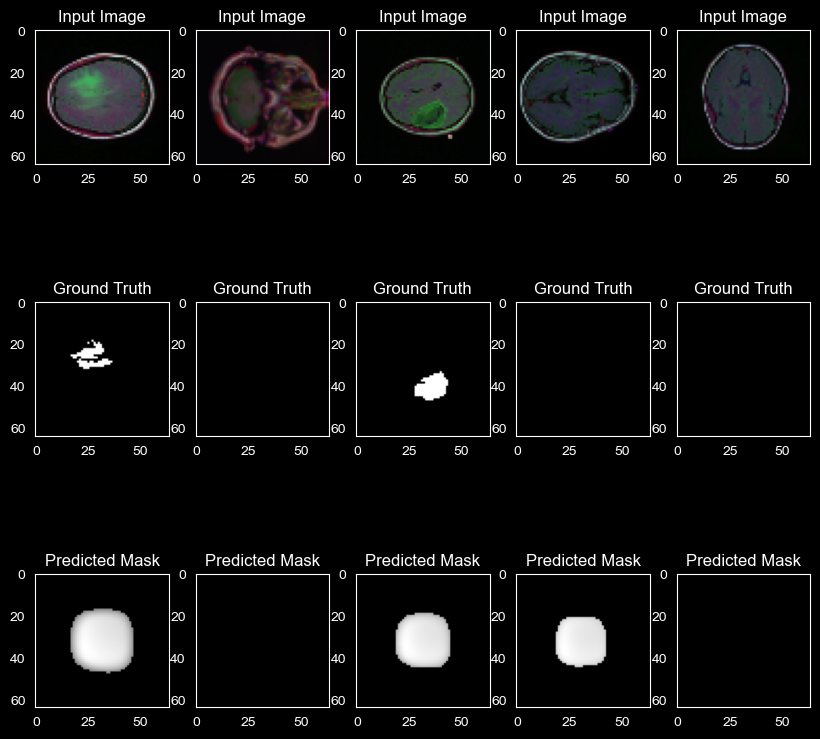

In [9]:
# Visualize the model predictions
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(dataloader))
        images = images.to(device)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225] 
        labels = labels.to(device)
        with torch.no_grad():
            outputs = predict(images)
        outputs[outputs < 0.1] = 0
        images = images.cpu().numpy()
        labels = labels.cpu().numpy()
        outputs = outputs.cpu().numpy()
        fig, axes = plt.subplots(3, num_images, figsize=(10, 10))
        for i in range(num_images):
            axes[0, i].imshow((images[i].transpose(1, 2, 0)*std + mean).clip(0, 1))
            axes[0, i].set_title("Input Image")
            axes[1, i].imshow(labels[i].squeeze(), cmap='gray')
            axes[1, i].set_title("Ground Truth")
            axes[2, i].imshow(outputs[i].squeeze(), cmap='gray')
            axes[2, i].set_title("Predicted Mask")

visualize_predictions(vae, test_loader)